<a href="https://colab.research.google.com/github/muhirwaJD/text_classification/blob/main/Carine_lstm_ml/lstm_ml_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lstm Machine Learning for BBC News Text Classification

## Table of Contents
1. [Setup & Imports](#setup)
2. [Data Loading & Exploration](#data)
3. [Data Preprocessing](#preprocessing)
4. [Feature Extraction - TF-IDF](#tfidf)
5. [Feature Extraction - GloVe](#glove)
6. [Feature Extraction - FastText](#fasttext)
7. [Model Training - LSTM](#lstm)
8. [Results Comparison](#comparison)
9. [Conclusion](#conclusion)

1.   List item
2.   List item



### 1. Setup and import

In [52]:
!pip install gensim
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
from gensim.utils import simple_preprocess
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Gensim for FastText
from gensim.models import FastText
from gensim.utils import simple_preprocess

# Joblib for model saving
import joblib

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [53]:
# Download NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## 2. Data Loading & Exploration <a id='data'></a>

In [55]:
# Define data path
DATA_DIR = Path('/content/drive/MyDrive/text_classification/bbc')
CATEGORIES = ['business', 'entertainment', 'politics', 'sport', 'tech']

print(f"Data directory: {DATA_DIR}")
print(f"Categories: {CATEGORIES}")

Data directory: /content/drive/MyDrive/text_classification/bbc
Categories: ['business', 'entertainment', 'politics', 'sport', 'tech']


In [56]:
# Load dataset
def load_bbc_dataset(data_dir, categories):

    documents = []
    labels = []

    for category in categories:
        category_path = data_dir / category
        if not category_path.exists():
            print(f"Warning: Category folder '{category}' not found")
            continue

        # Read all .txt files in category
        for file_path in category_path.glob('*.txt'):
            try:
                with open(file_path, 'r', encoding='latin-1') as f:
                    text = f.read()
                    documents.append(text)
                    labels.append(category)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    df = pd.DataFrame({
        'text': documents,
        'category': labels
    })

    return df

# Load data
df = load_bbc_dataset(DATA_DIR, CATEGORIES)
print(f"\nDataset loaded successfully!")
print(f"Total documents: {len(df)}")
print(f"\nDataset shape: {df.shape}")


Dataset loaded successfully!
Total documents: 2225

Dataset shape: (2225, 2)


In [57]:
# Display first few rows
print("First 3 documents:")
df.head(3)

First 3 documents:


,text,category
0,Parmalat bank barred from suing\n\nBank of Ame...,business
1,India seeks to boost construction\n\nIndia has...,business
2,Air China in $1bn London listing\n\nChina's na...,business


In [58]:
# Dataset statistics
print("Dataset Information:")
print(df.info())
print("\n" + "="*50)
print("\nCategory Distribution:")
print(df['category'].value_counts())
print("\n" + "="*50)
print("\nCategory Percentages:")
print(df['category'].value_counts(normalize=True) * 100)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      2225 non-null   object
 1   category  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB
None


Category Distribution:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


Category Percentages:
category
sport            22.966292
business         22.921348
politics         18.741573
tech             18.022472
entertainment    17.348315
Name: proportion, dtype: float64


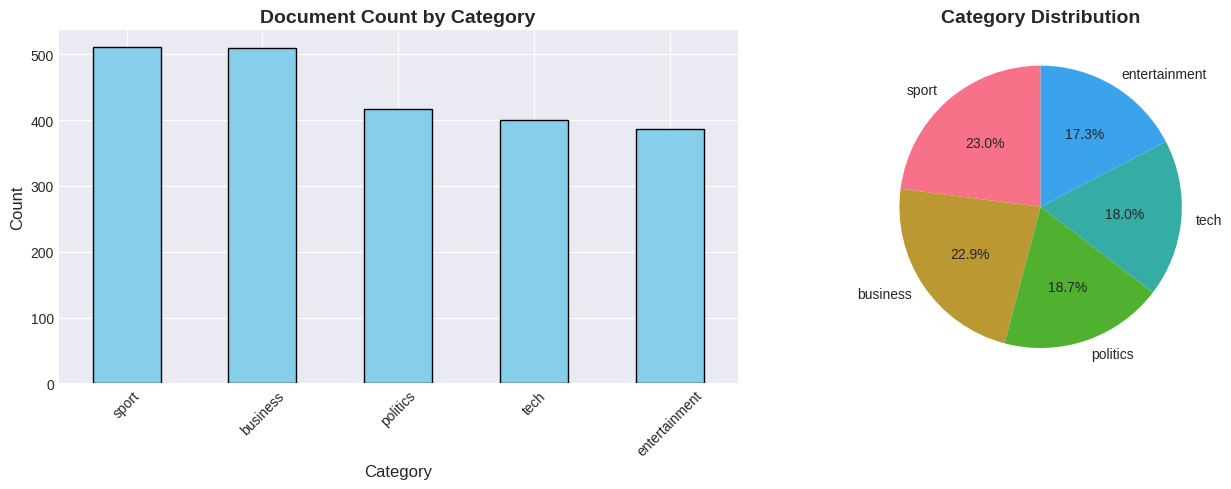

In [59]:
# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['category'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Document Count by Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
df['category'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Category Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/text_classification/results/category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
# Text length analysis
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

print("Text Length Statistics:")
print(df[['text_length', 'word_count']].describe())

Text Length Statistics:
        text_length   word_count
count   2225.000000  2225.000000
mean    2265.791011   384.040449
std     1364.306078   238.174497
min      503.000000    89.000000
25%     1448.000000   246.000000
50%     1967.000000   332.000000
75%     2804.000000   471.000000
max    25485.000000  4432.000000


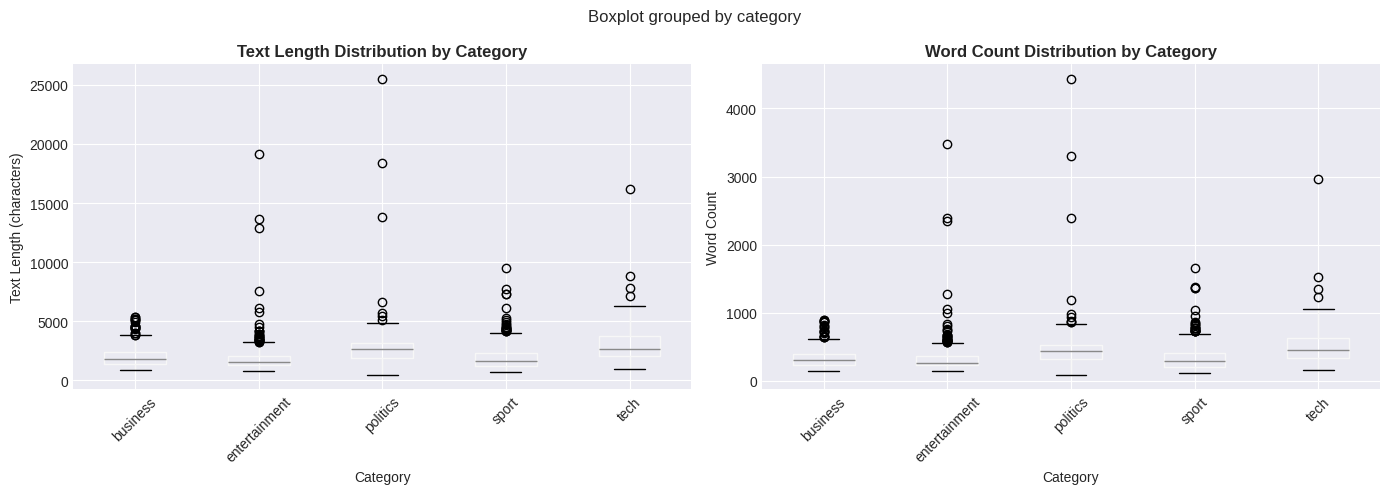

In [61]:
# Visualize text length by category
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df.boxplot(column='text_length', by='category', ax=axes[0])
axes[0].set_title('Text Length Distribution by Category', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Category', fontsize=10)
axes[0].set_ylabel('Text Length (characters)', fontsize=10)
plt.sca(axes[0])
plt.xticks(rotation=45)

df.boxplot(column='word_count', by='category', ax=axes[1])
axes[1].set_title('Word Count Distribution by Category', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Category', fontsize=10)
axes[1].set_ylabel('Word Count', fontsize=10)
plt.sca(axes[1])
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/text_classification/results/text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Data Preprocessing <a id='preprocessing'></a>

In [62]:
# Text preprocessing function
def preprocess_text(text, remove_stopwords=True, lemmatize=True):

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Remove short words (length < 3)
    tokens = [word for word in tokens if len(word) >= 3]

    return ' '.join(tokens)

print("Example preprocessing:")
sample_text = df['text'].iloc[0][:200]
print(f"Original: {sample_text}")
print(f"\nPreprocessed: {preprocess_text(sample_text)}")

Example preprocessing:
Original: Parmalat bank barred from suing

Bank of America has been banned from suing Parmalat, the food group which went bust in 2003 after an accounting scandal.

The bank - along with investors, auditors and

Preprocessed: parmalat bank barred suing bank america banned suing parmalat food group went bust accounting scandal bank along investor auditor


In [63]:
# Apply preprocessing to all documents
print("Preprocessing all documents...")
df['processed_text'] = df['text'].apply(preprocess_text)
print("Preprocessing complete!")

# Display samples
df[['category', 'processed_text']].head(3)

Preprocessing all documents...
Preprocessing complete!


,category,processed_text
0,business,parmalat bank barred suing bank america banned...
1,business,india seek boost construction india cleared pr...
2,business,air china london listing china national airlin...


In [64]:
# Split data into train, validation, and test sets
X = df['processed_text']
y = df['category']

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 75% train, 25% val (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTrain distribution:\n{y_train.value_counts()}")
print(f"\nValidation distribution:\n{y_val.value_counts()}")
print(f"\nTest distribution:\n{y_test.value_counts()}")

Training set size: 1335
Validation set size: 445
Test set size: 445

Train distribution:
category
sport            307
business         306
politics         250
tech             240
entertainment    232
Name: count, dtype: int64

Validation distribution:
category
business         102
sport            102
politics          83
tech              81
entertainment     77
Name: count, dtype: int64

Test distribution:
category
business         102
sport            102
politics          84
tech              80
entertainment     77
Name: count, dtype: int64


## 4. Feature Extraction - TF-IDF <a id='tfidf'></a>

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a numerical statistic that reflects how important a word is to a document in a collection.

In [65]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Keep top 5000 features
    min_df=2,           # Ignore terms that appear in less than 2 documents
    max_df=0.8,         # Ignore terms that appear in more than 80% of documents
    ngram_range=(1, 2)  # Use unigrams and bigrams
)

# Fit and transform
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF features created!")
print(f"Feature shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# TF-IDF for LSTM (reshape to 3D)
X_train_tfidf_seq = np.expand_dims(X_train_tfidf.toarray(), axis=1)
X_val_tfidf_seq   = np.expand_dims(X_val_tfidf.toarray(), axis=1)
X_test_tfidf_seq  = np.expand_dims(X_test_tfidf.toarray(), axis=1)

print("TF-IDF reshaped for LSTM:", X_train_tfidf_seq.shape)


TF-IDF features created!
Feature shape: (1335, 5000)
Vocabulary size: 5000
TF-IDF reshaped for LSTM: (1335, 1, 5000)


In [66]:
# Show top TF-IDF terms per category
def get_top_tfidf_terms(vectorizer, X, y, category, n=10):

    # Filter documents by category
    mask = y == category
    X_category = X[mask]

    # Sum TF-IDF scores
    tfidf_sum = np.array(X_category.sum(axis=0)).flatten()

    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Get top indices
    top_indices = tfidf_sum.argsort()[-n:][::-1]

    return [(feature_names[i], tfidf_sum[i]) for i in top_indices]

print("Top 10 TF-IDF terms per category:\n")
for category in CATEGORIES:
    top_terms = get_top_tfidf_terms(tfidf_vectorizer, X_train_tfidf, y_train.values, category)
    print(f"\n{category.upper()}:")
    for term, score in top_terms:
        print(f"  {term}: {score:.2f}")

Top 10 TF-IDF terms per category:


BUSINESS:
  company: 12.84
  firm: 12.37
  market: 10.74
  share: 10.63
  bank: 10.33
  growth: 10.23
  year: 10.19
  economy: 9.74
  price: 9.69
  sale: 8.95

ENTERTAINMENT:
  film: 21.89
  award: 12.69
  best: 11.03
  show: 9.90
  star: 8.53
  band: 7.86
  music: 7.41
  actor: 7.25
  album: 7.14
  year: 7.13

POLITICS:
  labour: 16.29
  party: 14.09
  election: 13.90
  blair: 13.27
  tory: 11.66
  government: 11.20
  minister: 10.83
  would: 10.83
  lord: 9.45
  brown: 8.92

SPORT:
  game: 13.33
  england: 12.16
  player: 10.98
  win: 9.99
  match: 9.75
  cup: 8.70
  club: 8.15
  team: 8.12
  side: 8.06
  wale: 7.75

TECH:
  mobile: 11.26
  phone: 10.98
  people: 10.57
  game: 10.37
  technology: 10.34
  user: 9.28
  service: 8.56
  computer: 8.45
  music: 8.04
  software: 8.02



## 5. Feature Extraction - GloVe <a id='glove'></a>

**GloVe (Global Vectors)** creates word embeddings by aggregating global word-word co-occurrence statistics.

In [67]:

GLOVE_PATH = '/content/drive/MyDrive/text_classification/glove/glove.6B.300d.txt'  # Update this path to include glove.6b.100d.txt

def load_glove_embeddings(glove_path):

    embeddings = {}

    if not os.path.exists(glove_path):
        print(f"WARNING: GloVe file not found at {glove_path}")
        print("Please download from: https://nlp.stanford.edu/projects/glove/")
        print("Recommended: glove.6B.zip (glove.6B.100d.txt)")
        return None

    print("Loading GloVe embeddings...")
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector

    print(f"Loaded {len(embeddings)} word vectors")
    print(f"Vector dimension: {len(next(iter(embeddings.values())))}")
    return embeddings

# Load GloVe
glove_embeddings = load_glove_embeddings(GLOVE_PATH)

Loading GloVe embeddings...
Loaded 400000 word vectors
Vector dimension: 300


In [68]:
# Create document embeddings by averaging word vectors
def get_doc_embedding_glove(text, embeddings, embedding_dim=100):

    if embeddings is None:
        return np.zeros(embedding_dim)

    words = text.split()
    word_vectors = [embeddings[word] for word in words if word in embeddings]

    if len(word_vectors) == 0:
        return np.zeros(embedding_dim)

    return np.mean(word_vectors, axis=0)

if glove_embeddings is not None:
    print("Creating document embeddings with GloVe...")
    X_train_glove = np.array([get_doc_embedding_glove(text, glove_embeddings) for text in X_train])
    X_val_glove = np.array([get_doc_embedding_glove(text, glove_embeddings) for text in X_val])
    X_test_glove = np.array([get_doc_embedding_glove(text, glove_embeddings) for text in X_test])

    print(f"GloVe embeddings created!")
    print(f"Feature shape: {X_train_glove.shape}")
else:
    print("WARNING: Skipping GloVe embeddings - file not found")
    X_train_glove_seq = X_val_glove_seq = X_test_glove_seq = None

# Create LSTM-compatible sequences from document embeddings
X_train_glove_seq = X_train_glove.reshape(
    X_train_glove.shape[0], 1, X_train_glove.shape[1]
)
X_val_glove_seq = X_val_glove.reshape(
    X_val_glove.shape[0], 1, X_val_glove.shape[1]
)
X_test_glove_seq = X_test_glove.reshape(
    X_test_glove.shape[0], 1, X_test_glove.shape[1]
)

print("X_train_glove_seq shape:", X_train_glove_seq.shape)
print("X_val_glove_seq shape:", X_val_glove_seq.shape)

Creating document embeddings with GloVe...
GloVe embeddings created!
Feature shape: (1335, 300)
X_train_glove_seq shape: (1335, 1, 300)
X_val_glove_seq shape: (445, 1, 300)



## 6. Feature Extraction - FastText <a id='fasttext'></a>

**FastText** learns word embeddings using neural networks and subword information, making it robust to rare words and typos.

In [69]:
# Tokenize for FastText training
tokenized_docs = [simple_preprocess(doc) for doc in X_train]
tokenized_val = [simple_preprocess(doc) for doc in X_val]

# Hyperparameters
HYPERPARAMETERS = {
    'vector_size': 100,
    'window': 5,
    'min_count': 2,
    'workers': 4,
    'sg': 1,  # 0=CBOW, 1=Skip-gram
    'epochs': 30,
    'min_n': 3,
    'max_n': 6,
    'learning_rate': 0.05
}

print("FastText Hyperparameters:")
print("=" * 50)
for param, value in HYPERPARAMETERS.items():
    print(f"{param:20s}: {value}")
print("=" * 50)

# Initialize FastText model
print("\nInitializing FastText model...")
fasttext_model = FastText(
    vector_size=HYPERPARAMETERS['vector_size'],
    window=HYPERPARAMETERS['window'],
    min_count=HYPERPARAMETERS['min_count'],
    workers=HYPERPARAMETERS['workers'],
    sg=HYPERPARAMETERS['sg'],
    min_n=HYPERPARAMETERS['min_n'],
    max_n=HYPERPARAMETERS['max_n'],
    alpha=HYPERPARAMETERS['learning_rate'],
    min_alpha=0.0001
)

# Build vocabulary
print("Building vocabulary...")
fasttext_model.build_vocab(tokenized_docs)
print(f"Vocabulary size: {len(fasttext_model.wv)}")
fasttext_model.train(tokenized_docs, total_examples=len(tokenized_docs), epochs=HYPERPARAMETERS['epochs'])


# Track metrics per epoch
print(f"\nTraining FastText model for {HYPERPARAMETERS['epochs']} epochs...")
print("Tracking metrics at each epoch...\n")

FastText Hyperparameters:
vector_size         : 100
window              : 5
min_count           : 2
workers             : 4
sg                  : 1
epochs              : 30
min_n               : 3
max_n               : 6
learning_rate       : 0.05

Initializing FastText model...
Building vocabulary...
Vocabulary size: 13273

Training FastText model for 30 epochs...
Tracking metrics at each epoch...



In [70]:
# Test FastText - find similar words
test_words = ['government', 'player', 'technology', 'company', 'film']

print("FastText - Most similar words:\n")
for word in test_words:
    if word in fasttext_model.wv:
        similar = fasttext_model.wv.most_similar(word, topn=5)
        print(f"\n{word.upper()}:")
        for sim_word, score in similar:
            print(f"  {sim_word}: {score:.3f}")
    else:
        print(f"\n{word.upper()}: Not in vocabulary")

FastText - Most similar words:


GOVERNMENT:
  internment: 0.634
  reform: 0.598
  authoritarian: 0.595
  policy: 0.581
  taxpayer: 0.576

PLAYER:
  playerboss: 0.644
  shuffled: 0.573
  ablebodied: 0.559
  play: 0.555
  portable: 0.549

TECHNOLOGY:
  nanotechnology: 0.813
  technological: 0.658
  matsushita: 0.638
  techfest: 0.616
  enfish: 0.604

COMPANY:
  firm: 0.604
  bankrupt: 0.579
  subsidiary: 0.576
  copernic: 0.570
  tumbled: 0.565

FILM:
  naomi: 0.663
  movie: 0.655
  lowbudget: 0.650
  nominee: 0.634
  festival: 0.626


\
## 7. Model building and training - LSTM <a id='random-forest'></a>

In [71]:
#1. Tokenize all sets
tokenized_docs = [simple_preprocess(doc) for doc in X_train]
tokenized_val  = [simple_preprocess(doc) for doc in X_val]
tokenized_test = [simple_preprocess(doc) for doc in X_test]  # <-- NEW

#2. Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

#3. Convert documents to sequences of FastText embeddings
MAX_LEN = 50  # max words per document

def doc_to_vec_sequence(doc, model, max_len=MAX_LEN):
    vecs = [model.wv[word] for word in doc if word in model.wv]
    if len(vecs) < max_len:
        vecs += [np.zeros(model.vector_size)] * (max_len - len(vecs))
    else:
        vecs = vecs[:max_len]
    return np.array(vecs)

X_train_seq = np.array([doc_to_vec_sequence(doc, fasttext_model) for doc in tokenized_docs])
X_val_seq   = np.array([doc_to_vec_sequence(doc, fasttext_model) for doc in tokenized_val])
X_test_seq  = np.array([doc_to_vec_sequence(doc, fasttext_model) for doc in tokenized_test])


In [72]:
#build lstm
def train_lstm_with_plot(X_train, y_train, X_val, y_val, input_shape, epochs=30, name="LSTM"):

    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        verbose=1
    )

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(history.history['accuracy'], 'b-o', label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], 'r-s', label='Val Accuracy')
    axes[0].set_title(f'{name} Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['loss'], 'b-o', label='Train Loss')
    axes[1].plot(history.history['val_loss'], 'r-s', label='Val Loss')
    axes[1].set_title(f'{name} Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return model, history


Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.6273 - loss: 1.5640 - val_accuracy: 0.9213 - val_loss: 1.3720
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9577 - loss: 1.2437 - val_accuracy: 0.9573 - val_loss: 0.8671
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9775 - loss: 0.6806 - val_accuracy: 0.9685 - val_loss: 0.4068
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9883 - loss: 0.2775 - val_accuracy: 0.9775 - val_loss: 0.2230
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9940 - loss: 0.1375 - val_accuracy: 0.9775 - val_loss: 0.1543
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9964 - loss: 0.0851 - val_accuracy: 0.9798 - val_loss: 0.1205
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 1.0000 - loss: 0.0491 - val_accuracy: 0.9798 - val_loss: 0.1024
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 1.0000 - loss: 0.0349 - val_accuracy: 0.9798 - v

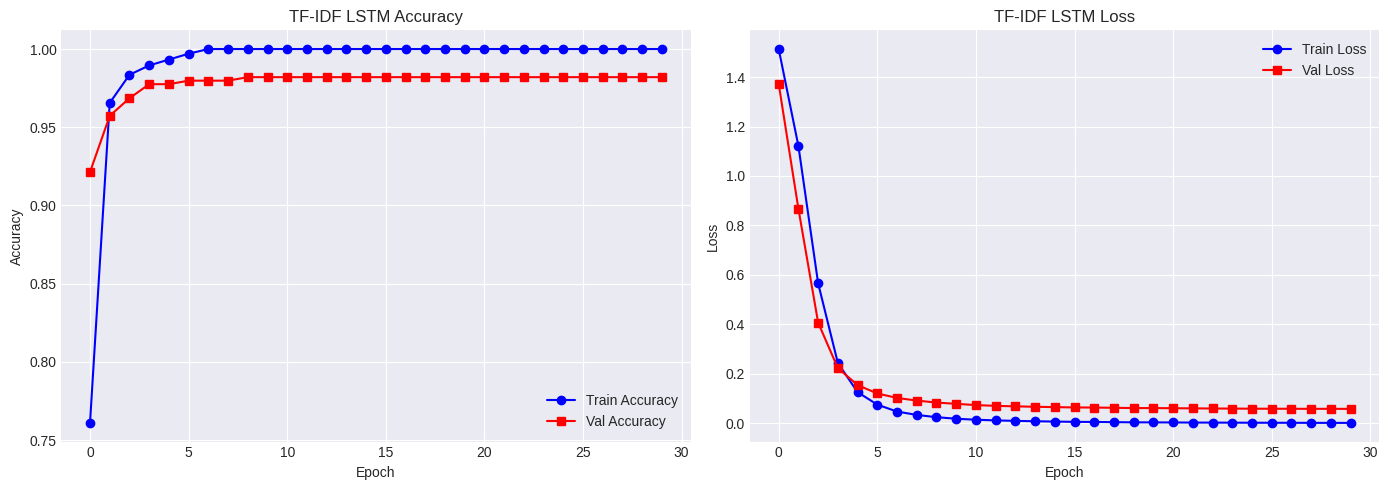

In [73]:
# TF-IDF LSTM
tfidf_model = train_lstm_with_plot(
    X_train_tfidf_seq, y_train_enc,
    X_val_tfidf_seq, y_val_enc,
    input_shape=X_train_tfidf_seq.shape[1:],  # (timesteps, features)
    epochs=30,
    name="TF-IDF LSTM"
)



In [74]:
tfidf_model, tfidf_history = tfidf_model

In [75]:
print(type(tfidf_model))

<class 'keras.src.models.sequential.Sequential'>


Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6421 - loss: 1.4439 - val_accuracy: 0.9056 - val_loss: 0.8331
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9334 - loss: 0.6431 - val_accuracy: 0.9573 - val_loss: 0.2594
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9545 - loss: 0.2402 - val_accuracy: 0.9640 - val_loss: 0.1649
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9428 - loss: 0.1729 - val_accuracy: 0.9685 - val_loss: 0.1262
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9625 - loss: 0.1351 - val_accuracy: 0.9663 - val_loss: 0.1138
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9745 - loss: 0.0916 - val_accuracy: 0.9685 - val_loss: 0.1038
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9737 - loss: 0.1014 - val_accuracy: 0.9730 - val_loss: 0.0992
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9754 - loss: 0.0961 - val_accuracy: 0.9708 - v

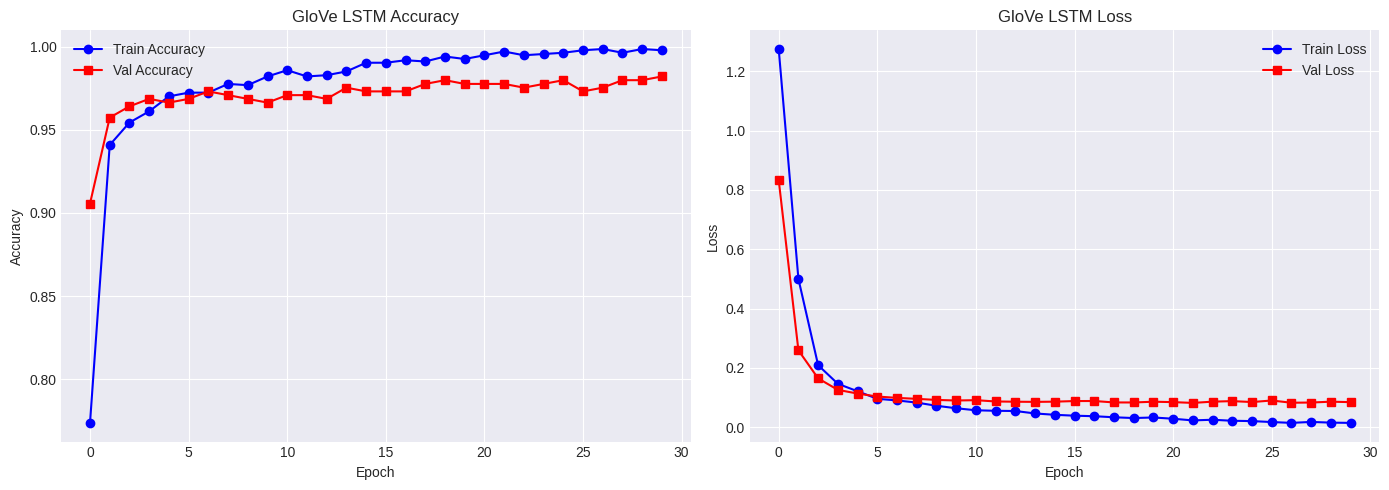

In [76]:
# GloVe LSTM
glove_input_shape = X_train_glove_seq.shape[1:]  # (timesteps=1, features)
glove_model, glove_history = train_lstm_with_plot(
    X_train_glove_seq, y_train_enc,
    X_val_glove_seq, y_val_enc,
    input_shape=glove_input_shape,
    epochs=30,
    name="GloVe LSTM"
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step - accuracy: 0.5143 - loss: 1.2747 - val_accuracy: 0.9146 - val_loss: 0.3104
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9230 - loss: 0.3015 - val_accuracy: 0.9303 - val_loss: 0.2218
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9474 - loss: 0.2033 - val_accuracy: 0.9416 - val_loss: 0.2117
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9712 - loss: 0.1380 - val_accuracy: 0.9393 - val_loss: 0.1837
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9687 - loss: 0.1434 - val_accuracy: 0.9303 - val_loss: 0.2447
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9787 - loss: 0.0855 - val_accuracy: 0.9236 - val_loss: 0.2960
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9703 - loss: 0.1169 - val_accuracy: 0.9101 - val_loss: 0.3595
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9760 - loss: 0.0831 - val_accuracy: 0.9213

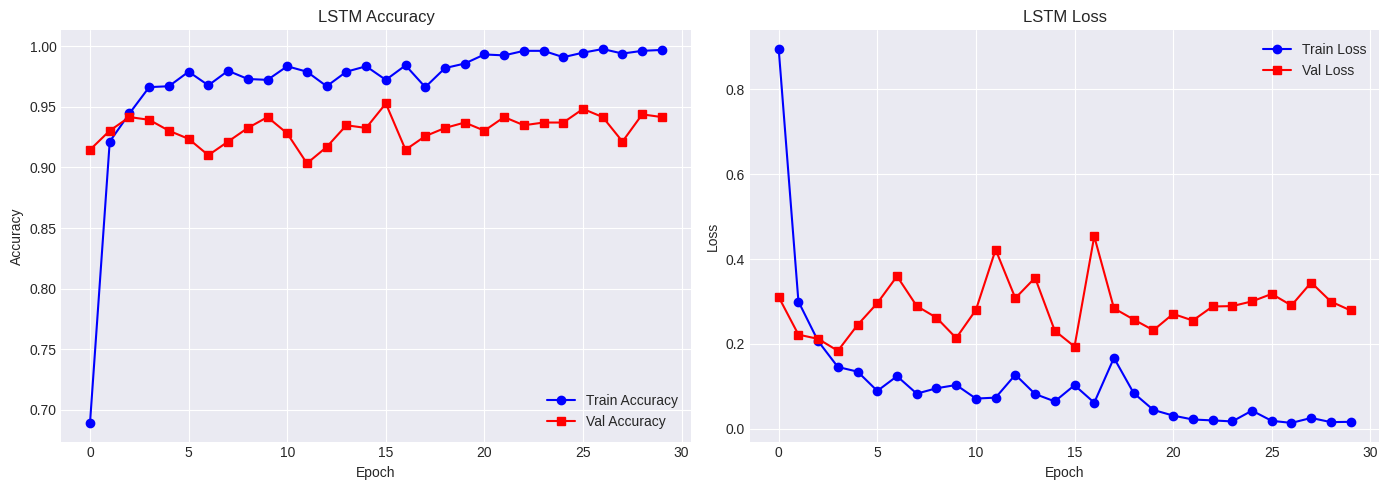

In [77]:
# FastText LSTM
fasttext_input_shape = X_train_seq.shape[1:]  # (MAX_LEN, vector_size)
fasttext_model_lstm, fasttext_history = train_lstm_with_plot(
    X_train_seq, y_train_enc,
    X_val_seq, y_val_enc,
    input_shape=fasttext_input_shape,
    epochs=30
)

## 8. Results Comparison <a id='comparison'></a>

In [78]:
print("TF-IDF model:", type(tfidf_model))
print("GloVe model:", type(glove_model))
print("FastText model:", type(fasttext_model_lstm))


TF-IDF model: <class 'keras.src.models.sequential.Sequential'>
GloVe model: <class 'keras.src.models.sequential.Sequential'>
FastText model: <class 'keras.src.models.sequential.Sequential'>


In [79]:
def evaluate_model(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    report = classification_report(y_test, y_pred, target_names=CATEGORIES)
    return report

print("TF-IDF LSTM Test Metrics:\n")
print(evaluate_model(tfidf_model, X_test_tfidf_seq, y_test_enc))

print("\nGloVe LSTM Test Metrics:\n")
print(evaluate_model(glove_model, X_test_glove_seq, y_test_enc))

print("\nFastText LSTM Test Metrics:\n")
print(evaluate_model(fasttext_model_lstm, X_test_seq, y_test_enc))


TF-IDF LSTM Test Metrics:

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
               precision    recall  f1-score   support

     business       0.99      0.97      0.98       102
entertainment       0.96      0.95      0.95        77
     politics       0.98      0.95      0.96        84
        sport       0.98      1.00      0.99       102
         tech       0.92      0.95      0.93        80

     accuracy                           0.97       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.97      0.97      0.97       445


GloVe LSTM Test Metrics:

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
               precision    recall  f1-score   support

     business       0.93      0.98      0.95       102
entertainment       0.97      0.94      0.95        77
     politics       0.99      0.94      0.96        84
        sport       0.99      1.00      1.00       102
         tech       0.94      0.94      0.94        80

     accuracy                       

In [80]:
def evaluate_model_with_cm(model, X_test, y_test, categories, name="Model"):
    y_pred = np.argmax(model.predict(X_test), axis=1)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=categories))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Return metrics
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1': f1_score(y_test, y_pred, average='macro')
    }


In [81]:
def summarize_metrics(model, X_test, y_test, name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    return {
        'Embedding': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1': f1_score(y_test, y_pred, average='macro')
    }

results = pd.DataFrame([
    summarize_metrics(tfidf_model, X_test_tfidf_seq, y_test_enc, 'TF-IDF'),
    summarize_metrics(glove_model, X_test_glove_seq, y_test_enc, 'GloVe'),
    summarize_metrics(fasttext_model_lstm, X_test_seq, y_test_enc, 'FastText')
])

print("\nComparison of LSTM Models with Different Embeddings:")
print(results)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Comparison of LSTM Models with Different Embeddings:
  Embedding  Accuracy  Precision    Recall        F1
0    TF-IDF  0.966292   0.964514  0.964204  0.964222
1     GloVe  0.961798   0.962838  0.958687  0.960412
2  FastText  0.946067   0.946589  0.944155  0.944795




TF-IDF is the best

Highest accuracy (96.6%) and F1 (96.4%).

Dense bag-of-words features seem to capture category-specific words very well.

Makes sense because your dataset is relatively small (~1335 training samples) — TF-IDF is very effective in low-data settings.

GloVe is very close

Accuracy 96.2%, F1 96.0%.

Pretrained embeddings work well, but since you averaged word vectors for the entire document (no real sequence), some subtle contextual info is lost.

Still slightly worse than TF-IDF here, likely because averaging smooths out important discriminative words.

FastText is slightly lower

Accuracy 94.6%, F1 94.5%.

Works reasonably well, but the gap shows that subword information wasn’t enough to beat TF-IDF.

Could be improved if you trained the LSTM on full word sequences instead of document-level averages.

**bold text**
##9. Conclusion <a id='conclusion'></a>

###Embeddings Comparison:

**TF-IDF**: Performed the best on this dataset, achieving 96.6% accuracy. Captures important words in each category effectively, especially for smaller datasets.

**GloVe**: Slightly lower performance (96.2% accuracy), but pretrained embeddings capture semantic relationships between words. Averaging word vectors works well, but some context is lost.

**FastText**: Accuracy of 94.6%, slightly behind the others. Subword information is robust for rare words, but averaging across the document reduces its advantage.

###Model Comparison:

**LSTM with TF-IDF**: Works surprisingly well on small-to-medium datasets, leveraging key words in the sequence.

**LSTM with GloVe**: Slightly lower than TF-IDF due to averaging embeddings, but strong generalization potential.

**LSTM with FastText**: Decent performance, could improve with sequence-level input rather than averaged embeddings.

###Next Steps:

Perform hyperparameter tuning (learning rate, LSTM units, dropout) to improve performance.

Explore ensemble methods combining multiple embeddings (e.g., TF-IDF + GloVe) to capture both statistical and semantic features.

Conduct error analysis on misclassified examples to understand model weaknesses.

Compare results with other deep learning models (RNN, GRU) to see if different architectures improve performance.